####Data of localidades obtained from: https://bogota-laburbano.opendatasoft.com/explore/dataset/georeferencia-puntual-por-localidad/export/?flg=es&location=9,-74.17314,4.39997&basemap=jawg.streets&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6Imdlb3JlZmVyZW5jaWEtcHVudHVhbC1wb3ItbG9jYWxpZGFkIiwib3B0aW9ucyI6eyJmbGciOiJlcyJ9fSwiY2hhcnRzIjpbeyJhbGlnbk1vbnRoIjp0cnVlLCJ0eXBlIjoiY29sdW1uIiwiZnVuYyI6IkFWRyIsInlBeGlzIjoibG9uZ2l0dWQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjMjYzODkyIn1dLCJ4QXhpcyI6ImxvbmdpdHVkIiwibWF4cG9pbnRzIjo1MCwic29ydCI6IiJ9XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D

####Data of cases obtained from: https://datosabiertos.bogota.gov.co/dataset/numero-de-casos-confirmados-por-el-laboratorio-de-covid-19-bogota-d-c

####Data of venues obtained from: https://developer.foursquare.com


# **Capstone Project Code**

Analysis of COVID-19 information in the city of Bogotá

Import packages

In [ ]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn import preprocessing


Import database with coordinates from localidades

In [ ]:
#Import latitudes and longitudes of localidades
df1 = pd.read_csv('geodata.csv', sep=';')
df1.head()

,LOCALIDAD,LONGITUD,LATITUD,CODIGO,gp
0,BARRIOS UNIDOS,-74.084000,4.666400,12,"-74.084,4.6664"
1,ENGATIVA,-74.107200,4.707100,10,"-74.1072,4.7071"
2,SUMAPAZ,-74.315224,4.034746,20,"-74.315224,4.034746"
3,TEUSAQUILLO,-74.093800,4.644800,13,"-74.0938,4.6448"
4,LA CANDELARIA,-74.073900,4.593900,17,"-74.0739,4.5939"


Drop information that is not necessary

In [ ]:
df1.drop(['gp'], axis=1, inplace=True)
df1 = df1[df1.LOCALIDAD != 'BOGOTA']
df1.head()

,LOCALIDAD,LONGITUD,LATITUD,CODIGO
0,BARRIOS UNIDOS,-74.084000,4.666400,12
1,ENGATIVA,-74.107200,4.707100,10
2,SUMAPAZ,-74.315224,4.034746,20
3,TEUSAQUILLO,-74.093800,4.644800,13
4,LA CANDELARIA,-74.073900,4.593900,17


Create a map of the city with the location of every localidad

In [ ]:
boglat = 4.624335
boglong = -74.063644

In [ ]:
map_bog = folium.Map(location=[boglat, boglong], zoom_start=11)

# add markers to map
for lat, lng, localidad in zip(df1['LATITUD'], df1['LONGITUD'], df1['LOCALIDAD']):
    label = '{}'.format(localidad)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bog)  
    
map_bog

Get information about nearby venues for every localidad

In [3]:
#@title
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Localidad', 
                  'Localidad Latitude', 
                  'Localidad Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
LIMIT = 100

venues = getNearbyVenues(names=df1['LOCALIDAD'],
                          latitudes=df1['LATITUD'],
                          longitudes=df1['LONGITUD']
                        )

BARRIOS UNIDOS
ENGATIVA
SUMAPAZ
TEUSAQUILLO
LA CANDELARIA
SANTA FE
SUBA
FONTIBON
LOS MARTIRES
SAN CRISTOBAL
USME
PUENTE ARANDA
USAQUEN
BOSA
CIUDAD BOLIVAR
RAFAEL URIBE URIBE
KENNEDY
CHAPINERO
TUNJUELITO
ANTONIO NARIÑO


In [ ]:
print(venues.shape)
venues.head()

(468, 7)


,Localidad,Localidad Latitude,Localidad Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BARRIOS UNIDOS,4.6664,-74.084,Centro Canino Cruz Roja,4.665530,-74.086151,Dog Run
1,BARRIOS UNIDOS,4.6664,-74.084,Riquisimo - Postres y Helados Principal,4.668366,-74.083662,Dessert Shop
2,BARRIOS UNIDOS,4.6664,-74.084,Solo Postres,4.667903,-74.083965,Dessert Shop
3,BARRIOS UNIDOS,4.6664,-74.084,Campo de Practica Fedegolf,4.663400,-74.084510,Golf Course
4,BARRIOS UNIDOS,4.6664,-74.084,Postres La Enramada,4.667113,-74.084464,Dessert Shop


In [ ]:
venues.groupby('Localidad').count()


,Localidad Latitude,Localidad Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Localidad,,,,,,
ANTONIO NARIÑO,4,4,4,4,4,4
BARRIOS UNIDOS,48,48,48,48,48,48
BOSA,6,6,6,6,6,6
CHAPINERO,71,71,71,71,71,71
ENGATIVA,31,31,31,31,31,31
FONTIBON,7,7,7,7,7,7
KENNEDY,17,17,17,17,17,17
LA CANDELARIA,98,98,98,98,98,98
LOS MARTIRES,20,20,20,20,20,20


Classify the venues as opened or closed during the quarantine

In [ ]:
#iF IT CONTAINS JOINT, RESTAURANT, PLACE, FOOD, BAKERY, BREAKFAST, CAFÉ, COFFEE, CONVENIENCE STORE, DELI, DINNER, GROCERY, SUPERMARKET IS OPEN
openv = venues['Venue Category'].str.contains(pat = 'Joint|Restaurant|Place|Food|Bakery|Breakfast|Café|Coffee|Convenience|Deli|Dinner|Grocery|Supermarket')
venues['Open'] = openv

In [ ]:
openclose = venues.groupby(["Localidad", "Open"])["Venue"].count().reset_index(name="count")

In [ ]:
df1 = df1.sort_values(by=['LOCALIDAD']).reset_index(drop=True)
df1 = df1[df1['LOCALIDAD'].isin(venues['Localidad'])].reset_index(drop=True)

In [ ]:
numopen = openclose[openclose['Open']==True]
numopen = numopen.reset_index(drop = True)
numopen.drop(['Open'], axis=1, inplace=True)
numopen.rename(columns={'Localidad':'LOCALIDAD',
                          'count':'NUMOPEN'}, 
                 inplace=True)

numclose = openclose[openclose['Open']==False]
numclose = numclose.reset_index(drop = True)
numclose.drop(['Open'], axis=1, inplace=True)
numclose.rename(columns={'Localidad':'LOCALIDAD',
                          'count':'NUMCLOSE'}, 
                 inplace=True)

In [ ]:
df1=df1.merge(numopen, on='LOCALIDAD')
df1=df1.merge(numclose, on='LOCALIDAD')
df1.head()

,LOCALIDAD,LONGITUD,LATITUD,CODIGO,NUMOPEN,NUMCLOSE
0,ANTONIO NARIÑO,-74.1009,4.5486,15,2,2
1,BARRIOS UNIDOS,-74.0840,4.6664,12,16,32
2,BOSA,-74.1945,4.6305,7,2,4
3,CHAPINERO,-74.0467,4.6569,2,42,29
4,ENGATIVA,-74.1072,4.7071,10,20,11


Import data from COVID.19 confirmed cases

In [ ]:
df2 = pd.read_excel('covid.xlsm')
df2.dropna(inplace=True)
df2.reset_index(drop=True)
df2.head()

,ID,DATE,CITY,CODE,LOCALIDAD,AGE,SEX,KIND,LOCATION,STATE
0,1,2020-03-06,Bogota,1.0,Usaquen,19.0,F,Importado,Casa,Moderado
1,2,2020-03-10,Bogota,10.0,Engativa,22.0,F,Importado,Casa,Moderado
2,3,2020-03-10,Bogota,10.0,Engativa,28.0,F,Importado,Casa,Moderado
3,4,2020-03-12,Bogota,9.0,Fontibon,36.0,F,Importado,Casa,Moderado
4,5,2020-03-12,Bogota,8.0,Kennedy,42.0,F,Importado,Casa,Moderado


Erase data outside Bogotá

In [ ]:
df2 = df2[df2['CITY']=='Bogota']
df2.drop(['CITY'], axis=1, inplace=True)

Create a summary dataframe of the variables accumulated by localidad

In [ ]:
temp = df2['LOCALIDAD'].value_counts().to_frame()
temp = temp.reset_index()
temp.rename(columns={'LOCALIDAD':'CASES','index':'LOCALIDAD'}, inplace=True)
temp['LOCALIDAD'] = temp['LOCALIDAD'].str.upper() 
temp = temp[temp['LOCALIDAD']!= 'SIN DATO']

In [ ]:
# one hot encoding
Dumms = pd.get_dummies(df2[['KIND','LOCATION','SEX']], prefix="", prefix_sep="")
Dumms['Relacionado'] = Dumms['Relacionado']+Dumms['relacionado']
Dumms.drop(['relacionado'],axis=1,inplace=True)
Dumms['LOCALIDAD']=df2['LOCALIDAD']

Dumms2 = pd.get_dummies(df2[['STATE']], prefix="", prefix_sep="")
Dumms2.drop(['Fallecido'],axis=1,inplace=True)
Dumms2['LOCALIDAD']=df2['LOCALIDAD']
Dumms = Dumms.merge(Dumms2)

Dumms = Dumms.groupby(['LOCALIDAD'],as_index=False).sum()
Dumms['LOCALIDAD'] = Dumms['LOCALIDAD'].str.upper() 
Dumms = Dumms[Dumms['LOCALIDAD']!= 'SIN DATO']

df2.groupby(['LOCALIDAD'],as_index=False).sum()
Dumms = Dumms.merge(temp[['LOCALIDAD','CASES']], on='LOCALIDAD')

In [ ]:
Dumms = Dumms[Dumms['LOCALIDAD'].isin(df1['LOCALIDAD'])].reset_index(drop=True)
Dumms.shape

(14, 15)

Get descriptive statistics

In [ ]:
dfsummary = Dumms.merge(df1, on='LOCALIDAD')

dfsummary.describe()

,Desconocido,En estudio,Importado,Relacionado,Casa,Fallecido,Hospital,Hospital UCI,F,M,Critico,Moderado,Severo,CASES,LONGITUD,LATITUD,CODIGO,NUMOPEN,NUMCLOSE
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,1485.142857,10051.928571,3882.142857,3018.000000,16096.785714,838.285714,1023.571429,478.571429,9489.142857,8948.071429,478.571429,16096.785714,1023.571429,108.214286,-74.107114,4.645686,10.357143,17.428571,14.071429
std,2138.597163,12849.706465,5500.882529,3930.258594,19959.713568,1221.415032,1509.061691,734.325930,11989.810853,11031.448064,734.325930,19959.713568,1509.061691,85.113660,0.043986,0.064497,5.271216,21.664271,13.606923
min,0.000000,28.000000,0.000000,21.000000,42.000000,0.000000,0.000000,0.000000,28.000000,21.000000,0.000000,42.000000,0.000000,7.000000,-74.194500,4.548600,1.000000,1.000000,1.000000
25%,117.000000,1150.500000,165.000000,175.500000,1523.250000,81.000000,81.000000,0.000000,861.000000,891.750000,0.000000,1523.250000,81.000000,41.250000,-74.136200,4.599150,7.250000,2.250000,4.250000
50%,315.000000,3973.500000,1763.000000,1324.000000,7845.000000,175.000000,352.000000,98.500000,4432.500000,4490.000000,98.500000,7845.000000,352.000000,94.500000,-74.104050,4.637650,10.500000,8.500000,9.500000
75%,2664.000000,18079.500000,4169.500000,4278.000000,30888.000000,1349.000000,1246.500000,697.500000,18987.000000,16689.750000,697.500000,30888.000000,1246.500000,183.750000,-74.082800,4.679000,14.500000,19.000000,24.500000
max,6604.000000,36740.000000,16002.000000,11500.000000,56642.000000,3740.000000,5060.000000,2032.000000,32766.000000,31750.000000,2032.000000,56642.000000,5060.000000,254.000000,-74.031200,4.765200,18.000000,65.000000,40.000000


In [ ]:
cor = dfsummary.corr()
cor

,Desconocido,En estudio,Importado,Relacionado,Casa,Fallecido,Hospital,Hospital UCI,F,M,Critico,Moderado,Severo,CASES,LONGITUD,LATITUD,CODIGO,NUMOPEN,NUMCLOSE
Desconocido,1.000000,0.917055,0.874892,0.927016,0.975226,0.864588,0.788230,0.909438,0.971463,0.972757,0.909438,0.975226,0.788230,0.927827,0.204603,0.759177,-0.283637,-0.194209,-0.176270
En estudio,0.917055,1.000000,0.718332,0.831578,0.935164,0.983283,0.959071,0.976134,0.967033,0.946036,0.976134,0.935164,0.959071,0.939073,0.008553,0.619601,-0.338834,-0.217746,-0.210877
Importado,0.874892,0.718332,1.000000,0.958479,0.913843,0.680910,0.498831,0.741994,0.866932,0.904233,0.741994,0.913843,0.498831,0.857858,0.495760,0.870082,-0.464639,-0.074837,-0.071273
Relacionado,0.927016,0.831578,0.958479,1.000000,0.969135,0.785698,0.644270,0.810571,0.942937,0.957730,0.810571,0.969135,0.644270,0.931167,0.388200,0.845139,-0.477298,-0.092491,-0.108602
Casa,0.975226,0.935164,0.913843,0.969135,1.000000,0.898210,0.797591,0.922856,0.994242,0.998719,0.922856,1.000000,0.797591,0.973230,0.251514,0.797974,-0.422446,-0.160401,-0.160264
Fallecido,0.864588,0.983283,0.680910,0.785698,0.898210,1.000000,0.960365,0.978900,0.936611,0.914451,0.978900,0.898210,0.960365,0.895127,0.017615,0.557187,-0.312448,-0.229120,-0.204578
Hospital,0.788230,0.959071,0.498831,0.644270,0.797591,0.960365,1.000000,0.931321,0.856137,0.817727,0.931321,0.797591,1.000000,0.826064,-0.181758,0.422829,-0.231428,-0.228692,-0.216086
Hospital UCI,0.909438,0.976134,0.741994,0.810571,0.922856,0.978900,0.931321,1.000000,0.950265,0.939300,1.000000,0.922856,0.931321,0.904882,0.044855,0.608908,-0.312615,-0.220579,-0.178118
F,0.971463,0.967033,0.866932,0.942937,0.994242,0.936611,0.856137,0.950265,1.000000,0.996128,0.950265,0.994242,0.856137,0.973753,0.185544,0.752299,-0.398385,-0.179569,-0.177138
M,0.972757,0.946036,0.904233,0.957730,0.998719,0.914451,0.817727,0.939300,0.996128,1.000000,0.939300,0.998719,0.817727,0.974908,0.233484,0.786223,-0.418419,-0.166388,-0.161514


Create map with cases

In [ ]:
map_bog = folium.Map(location=[boglat, boglong], zoom_start=11)

for lat, lon, local, cases in zip(dfsummary['LATITUD'], dfsummary['LONGITUD'], dfsummary['LOCALIDAD'], dfsummary['CASES']):
    folium.CircleMarker(
        [lat, lon],
        popup = ('Localidad: ' + str(local).capitalize()),
        radius=.15*cases,
        color='b',
        threshold_scale=[0,1,2,3],
        fill_color='yellow',
        fill=True,
        fill_opacity=0.7
        ).add_to(map_bog)
map_bog


Create map with deaths

In [ ]:
map_bog = folium.Map(location=[boglat, boglong], zoom_start=11)

for lat, lon, local, death in zip(dfsummary['LATITUD'], dfsummary['LONGITUD'], dfsummary['LOCALIDAD'], dfsummary['Fallecido']):
    folium.CircleMarker(
        [lat, lon],
        popup = ('Localidad: ' + str(local).capitalize()),
        radius=.01*death,
        color='b',
        threshold_scale=[0,1,2,3],
        fill_color='red',
        fill=True,
        fill_opacity=0.7
        ).add_to(map_bog)
map_bog

Merge information into one dataframe

In [ ]:
df = df2
df['LOCALIDAD'] = df['LOCALIDAD'].str.upper() 
df = df[df['LOCALIDAD'].isin(df1['LOCALIDAD'])].reset_index(drop=True)
df1 = df1[df1['LOCALIDAD'].isin(df['LOCALIDAD'])].reset_index(drop=True)


In [ ]:
codes = df['CODE']
codes = codes-1
codes = codes.tolist()


In [ ]:
ndf1 =  df1.reindex(codes).reset_index(drop=True)
df['LATITUDE']=ndf1['LATITUD']
df['LONGITUDE']=ndf1['LONGITUD']
df['NUMOPEN']=ndf1['NUMOPEN']
df['NUMCLOSE']=ndf1['NUMCLOSE']
df['KIND'].replace('relacionado', 'Relacionado', inplace=True)

df.head()

,ID,DATE,CODE,LOCALIDAD,AGE,SEX,KIND,LOCATION,STATE,LATITUDE,LONGITUDE,NUMOPEN,NUMCLOSE
0,1,2020-03-06,1.0,USAQUEN,19.0,F,Importado,Casa,Moderado,4.5486,-74.1009,2.0,2.0
1,2,2020-03-10,10.0,ENGATIVA,22.0,F,Importado,Casa,Moderado,4.5653,-74.1164,1.0,1.0
2,3,2020-03-10,10.0,ENGATIVA,28.0,F,Importado,Casa,Moderado,4.5653,-74.1164,1.0,1.0
3,4,2020-03-12,9.0,FONTIBON,36.0,F,Importado,Casa,Moderado,4.6149,-74.1227,9.0,5.0
4,5,2020-03-12,8.0,KENNEDY,42.0,F,Importado,Casa,Moderado,4.5939,-74.0739,58.0,40.0


Generate bar plots of different interesting variables

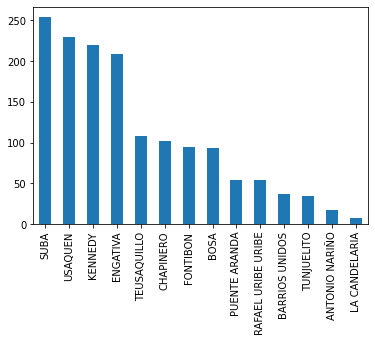

In [ ]:
df['LOCALIDAD'].value_counts().plot(kind='bar')

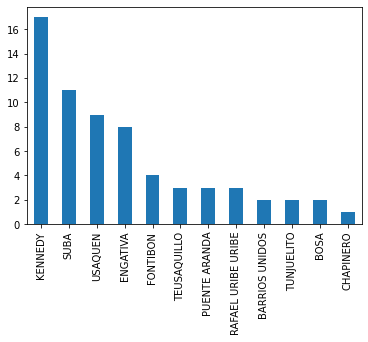

In [ ]:
df['LOCALIDAD'][df['STATE']=='Fallecido'].value_counts().plot(kind='bar')

In [ ]:
df.drop(['DATE','CODE','LOCALIDAD'], axis=1, inplace=True)

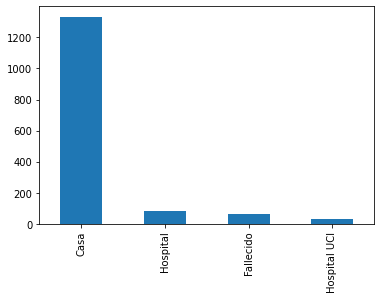

In [ ]:
df['LOCATION'].value_counts().plot(kind='bar')

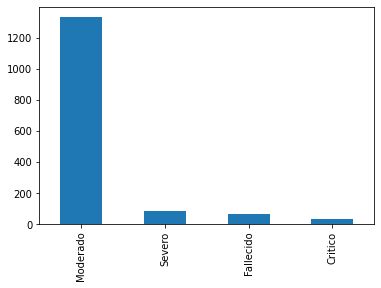

In [ ]:
df['STATE'].value_counts().plot(kind='bar')

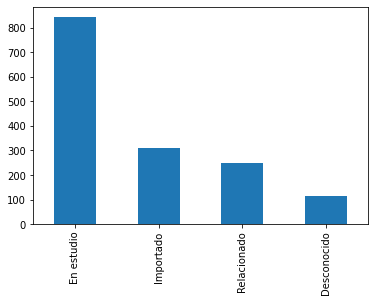

In [ ]:
df['KIND'].value_counts().plot(kind='bar')

Organize data to create a model

In [ ]:
df['KIND'].replace(['Importado', 'Relacionado', 'En estudio', 'Desconocido'], [0, 1, 2, 3], inplace=True)
df['LOCATION'].replace(['Casa', 'Hospital', 'Hospital UCI', 'Fallecido'], [0, 1, 2, 3], inplace=True)
df['STATE'].replace(['Moderado', 'Severo', 'Critico', 'Fallecido'], [0, 1, 2, 3], inplace=True)
df['SEX'].replace(['F', 'M'], [0, 1], inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True)

df.head()

,ID,AGE,SEX,KIND,LOCATION,STATE,LATITUDE,LONGITUDE,NUMOPEN,NUMCLOSE
0,1,19.0,0,0,0,0,4.5486,-74.1009,2.0,2.0
1,2,22.0,0,0,0,0,4.5653,-74.1164,1.0,1.0
2,3,28.0,0,0,0,0,4.5653,-74.1164,1.0,1.0
3,4,36.0,0,0,0,0,4.6149,-74.1227,9.0,5.0
4,5,42.0,0,0,0,0,4.5939,-74.0739,58.0,40.0


In [ ]:
df.shape

(1383, 10)

In [ ]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ndf = pd.DataFrame(x_scaled)

Divide data from labels and x into different sets

In [ ]:
#1 when needs hospital, 0 when not
labels = df['LOCATION']
labels.replace([2, 3], [1, 0], inplace=True)


In [ ]:
xtrain = ndf
xtrain = xtrain.drop([X.columns[3], X.columns[5]],  axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
x, X_test, y, y_test = train_test_split(xtrain,labels,test_size=0.2,train_size=0.8, random_state = 4)
X_train, X_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75, random_state = 4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
print ('Validation set:', X_cv.shape,  y_cv.shape)

Train set: (829, 8) (829,)
Test set: (277, 8) (277,)
Validation set: (277, 8) (277,)


In [ ]:
y_test.shape

(277,)

Optimize model

In [ ]:
#Find best model SVM

mean_acc = np.zeros((4))

from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
mean_acc[0]=metrics.accuracy_score(y_test, yhat)

clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
mean_acc[1]=metrics.accuracy_score(y_test, yhat)

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
mean_acc[2]=metrics.accuracy_score(y_test, yhat)

clf = svm.SVC(kernel='sigmoid')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
mean_acc[3]=metrics.accuracy_score(y_test, yhat)

print( "The best accuracy was with", mean_acc.max(), "with model=", mean_acc.argmax()) 

The best accuracy was with 0.9891696750902527 with model= 2


In [ ]:
#Since best model is poly we use this one to build model
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train) 
#Predict
yhatSVM = clf.predict(X_test)

array([0, 0, 0, 0, 0])

In [ ]:
from sklearn.linear_model import LogisticRegression

CS = [0.001,0.01,0.1]
mean_acc = np.zeros((3-1))
std_acc = np.zeros((3-1))
ConfustionMx = [];
for n in range(1, 3):
    
    #Train Model and Predict  
    LR = LogisticRegression(C=CS[n-1] , solver='liblinear').fit(X_train,y_train)
    yhat = LR.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)


mean_acc
print( "The best accuracy was with", mean_acc.max(), "with C =", (CS[mean_acc.argmax()+1])) 

The best accuracy was with 0.9025270758122743 with C = 0.01


In [ ]:
CS=CS[mean_acc.argmax()]
LR = LogisticRegression(C=CS, solver='liblinear').fit(X_train,y_train)
yhatLR = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

Evaluate models with validation set

In [ ]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [ ]:
yhatLR = LR.predict(X_cv)
yhat_prob = LR.predict_proba(X_cv)


In [ ]:
evaluations = ["Algorithm", "Jaccard", "F1-score"]
report = pd.DataFrame(columns = evaluations)

col1 = ["SVM","Logistic regression"]

col2 = [jaccard_similarity_score(y_cv, yhatSVM),jaccard_similarity_score(y_cv, yhatLR)]

col3 = [f1_score(y_cv, yhatSVM, average='weighted'),f1_score(y_cv, yhatLR, average='weighted')]

report["Algorithm"] = col1
report["Jaccard"] = col2
report["F1-score"] = col3

report.set_index('Algorithm', inplace=True)

report

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


,Jaccard,F1-score
Algorithm,,
SVM,0.837545,0.827067
Logistic regression,0.898917,0.851066
